## Применение скрытой марковской модели для анализа структуры участка генома

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

 ### В задаче распознавания фрагментов генов можно выделить 4 наблюдаемых величины - типы считуемых нуклеотидов - A, C, G, T. Используя аналогию с нечестным казино, пусть имеем 2 скрытых состояния. Тогда матрица перехода (transmision matrix) T = 2x2, а эмиссионная матрица (emision matrix) E = 2x4.

In [111]:
observable = ["A","C","G","T"]
states = [0, 1] #честному состоянию соответствует 0, смещенному - 1
m = 2 #количество скрытых состояний
k = 4 #количество возможных наблюдаемых состояний
L = 200 #длина генерируемой цепочки

## 1. Задаем матрицы T, E, а также начальное распределение pi

In [112]:
pi = np.array([0.5, 0.5]) #вероятности нахождения в каждом скрытом состоянии 
T = np.array([[0.95,0.05],[0.1,0.9]])
E = np.array([[1/k, 1/k, 1/k, 1/k],[0.1, 0.1, 0.1, 0.7]])

## 2. При заданных параметрех системы используем случайный генератор СММ для того, чтобы получить последовательность наблдаемых величин x длины L и соответствующую ей цепочку скрытых состояний.

In [113]:
def next_state(weights):
    choice = np.random.random() * sum(weights)
    for i, w in enumerate(weights):
        choice -= w
        if choice < 0:
            return i
        
#вычислим частоту состояний
count = 0
for i in range(L):
    count += next_state(pi)
#print ("Expected ratio number of Fair states:",(L - count)/L)
#print ("Expected ratio number of Biased states:", count/L)

def create_hidden_sequence(pi, T, L):
    out = [None]*L
    out[0] = next_state(pi)
    for i in range(1, L):
        out[i] = next_state(T[out[i-1]])
    return out
def create_observation_sequence(hidden_sequence, E):
    length = len(hidden_sequence)
    out = [None]*length
    for i in range(length):
        out[i] = next_state(E[hidden_sequence[i]])
    return out
hidden = np.array(create_hidden_sequence(pi, T, L))
observed = np.array(create_observation_sequence(hidden, E))
obs_map = {'A':0, 'C':1, 'G':2, 'T':3}
inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(observed)]

obs_seq = pd.DataFrame(np.column_stack([observed, obs_seq]), columns=['Obs_code', 'Obs_seq']) 
#print(observed)
hidd_seq = pd.DataFrame(hidden, columns = ["Hidd_seq"])
print(hidden) #последовательность скрытых состояний
out = obs_seq.join(hidd_seq)
#(out) #вывод полного состояния

[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [114]:
from hmmlearn import hmm
model = hmm.MultinomialHMM(n_components = m)
model.startprob_ = pi
model.transmat_ = T
model.emissionprob_ = E
X = model.sample(L)
#print(X[0]) #последовательность наблюдаемых состояний
print(X[1]) #последовательность скрытых состояний


[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 3. Используем алгоритм Витерби, чтобы восстановить последовательность скрытых состояний (выше - Х[1]).

In [115]:
def viterbi(observed):
    V = np.zeros((L, m))
    for j in range(m):
        V[0, j] = E[j, observed[0]]*pi[j]
    for i in range(1, L):
        for j in range(m):
            if j == 0:
                V[i, j] = E[j, observed[i]]*max(V[i-1][1]*T[1,0], V[i-1][j]*T[j, j])
            if j == 1:
                V[i, j] = E[j, observed[i]]*max(V[i-1][0]*T[0,1], V[i-1][j]*T[j,j])
    return V 
 

## Проиллюстрируеем работу алгоритма Витерби на примере имеющихся посдедовательностей

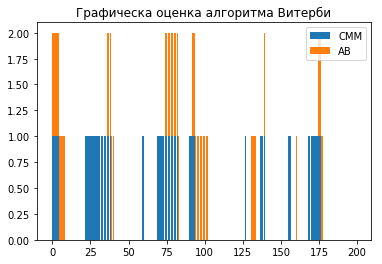

In [116]:
# вручную запрограммированный алгоритм СММ
V1 = viterbi(observed)
Vhidd_seq1 = np.argmax(V1, axis = 1) #искомая последовательность скрытых состояний
#print (pd.DataFrame(np.argmax(V1, axis = 1), columns = ['Vhidd_seq1']))
#print (pd.DataFrame(V1, columns = ['prob_state_1','prob_state_2']))
ind = np.arange(L) 
p1 = plt.bar(ind, hidden) 
p2 = plt.bar(ind, Vhidd_seq1, bottom = hidden)
plt.title('Графическа оценка алгоритма Витерби')
plt.legend((p1[0], p2[0]), ('СММ', 'АВ'))
plt.show()

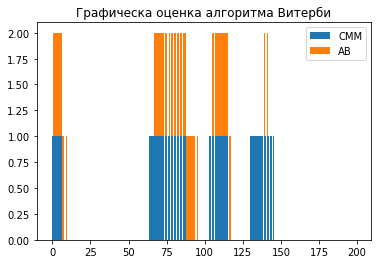

In [117]:
# встроенный аогоритм СММ
V2 = viterbi(X[0])
Vhidd_seq2 = np.argmax(V2, axis = 1) #искомая последовательность скрытых состояний
#print (pd.DataFrame(np.argmax(V2, axis = 1), columns = ['Vhidd_seq2']))
#print (pd.DataFrame(V2, column = ['prob_state_1','prob_state_2']))
ind = np.arange(L) 
p1 = plt.bar(ind, X[1]) 
p2 = plt.bar(ind, Vhidd_seq2, bottom = X[1])
plt.title('Графическа оценка алгоритма Витерби')
plt.legend((p1[0], p2[0]), ('СММ', 'АВ'))
plt.show()

### В обоих варинтах есть области несовпадания (когда над синей областью нет желтой или когда желтая область существует сама по себе), но, в целом, все ок. Работа запрограммированного вручную алгоритма ничем не отличается от результатов встроенного модуля.

## 3. Найдем вероятность сгенерированной цепочки наблюдаемых величин Х, используя прямой алгоритм (forward algorithm)

In [118]:
def forward(obs, states, pi, T, E):
    
    fwd = np.zeros((L+1, m))
    for j in range(m):
        fwd[0, j] = pi[j]
#    fwd[0] = pi
    
    for state in states:
        fwd[1, state] = pi[state]*E[state, obs[0]]
        
    for i in range(2, L+1):
        for state1 in states:
            for state2 in states:
                fwd[i, state1] += fwd[i - 1, state2]*T[state2, state1]    
            fwd[i, state1] *= E[state1, obs[i-1]]
    return fwd
F = forward(X[0], states, pi, T, E)
sum(forward(X[0], states, pi, T, E)[-1]) #sum(forward(observed, states, pi, T, E)[-1])

2.3422714665887095e-117

## 4. Выполним обратный алгоритм (backward algorithm)

In [125]:
def backward(obs, T, E, pi):

    bk = np.zeros((L+1, m))
    
    for j in range(m):
        bk[L, j] = pi[j]
    
    for i in range(L-1,-1,-1):
        for state1 in states:
            for state2 in states:
                bk[i, state1] += bk[i+1, state2]*T[state1, state2]
            bk[i, state1] *= E[state1, obs[i]]
    return bk
B = backward(X[0], T, E, pi) #B = backward(observed, T, E, pi)
sum(B[0])

2.3422714665887127e-117

### Вероятности, сгенерированные прямым и обратным алгоритмами, дают одинаковые значения.

## 5. Посчитаем апостериорную вероятность.

In [123]:
PS = np.zeros((L, m))
for i in range(L):
    for j in range(m):
        PS[i, j] = F[i][j]*B[i][j]/sum(B[0])
PS

array([[0.11230783, 0.38769217],
       [0.06190062, 0.42801793],
       [0.04263128, 0.48197208],
       [0.03880852, 0.49267584],
       [0.04638324, 0.47146662],
       [0.0733786 , 0.3958796 ],
       [0.14838815, 0.18585287],
       [0.34679078, 0.10649181],
       [0.41650408, 0.07860649],
       [0.43054249, 0.07299113],
       [0.4388243 , 0.04980207],
       [0.46925676, 0.03762909],
       [0.46880743, 0.03780882],
       [0.47217985, 0.02836603],
       [0.49073811, 0.02094272],
       [0.48851055, 0.02183375],
       [0.49148576, 0.01350318],
       [0.50968929, 0.00622176],
       [0.51601382, 0.00369195],
       [0.51708337, 0.00326413],
       [0.51401814, 0.00449022],
       [0.50360776, 0.00865437],
       [0.50370622, 0.00837869],
       [0.51464531, 0.00400305],
       [0.51853399, 0.00244758],
       [0.51944511, 0.00208313],
       [0.51833293, 0.002528  ],
       [0.51403258, 0.00424814],
       [0.50204011, 0.00904513],
       [0.5015259 , 0.01048491],
       [0.

 Что ж, сумма значений в строке не = 1, а это значит, что что-то пошло не так. Можем сравнить найденную апостериорную верояность с аналогичной функцией встроенного модуля. По не установленной мною причине, найденная вручную вероятность отличается от встроенной почти точно в два раза.

In [131]:
# аростериорная вероятноть 
model.predict_proba(X[0]) 

array([[0.22461567, 0.77538433],
       [0.12256324, 0.87743676],
       [0.09088645, 0.90911355],
       [0.09603322, 0.90396678],
       [0.14345501, 0.85654499],
       [0.28338106, 0.71661894],
       [0.66402127, 0.33597873],
       [0.80319595, 0.19680405],
       [0.84667012, 0.15332988],
       [0.83997658, 0.16002342],
       [0.90414586, 0.09585414],
       [0.91970962, 0.08029038],
       [0.90296862, 0.09703138],
       [0.94311425, 0.05688575],
       [0.95159126, 0.04840874],
       [0.93727805, 0.06272195],
       [0.97223917, 0.02776083],
       [0.9849713 , 0.0150287 ],
       [0.98880945, 0.01119055],
       [0.98777352, 0.01222648],
       [0.98077855, 0.01922145],
       [0.96049832, 0.03950168],
       [0.98146187, 0.01853813],
       [0.98915872, 0.01084128],
       [0.99165023, 0.00834977],
       [0.99154586, 0.00845414],
       [0.9887363 , 0.0112637 ],
       [0.98027896, 0.01972104],
       [0.95731601, 0.04268399],
       [0.97671036, 0.02328964],
       [0.